#Document-topic Maps Using Gensim and K-Means Clustering in Python

---



```
D.A.Anderson. 2022
```





**Topic maps** visualize the most important words and phrases occurring in text data. They give a bird's-eye view of text corpora  by extracting pertinent **keywords** which seem to comprise **high-level topics** throughout, and laying them out visually to suggest inter-relationships.  

Below I do a quick implementation of [**Selva Prabhakaran**](https://github.com/selva86)'s 2018 tutorial [**Topic Modelling with Gensim**](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) to make a [**Natural Language Processing (NLP)**](https://www.ibm.com/cloud/learn/natural-language-processing) tool that makes topic maps. 

Using survey responses as our text corpus here. The algorithm considers each person's response as one 'text', and it reads thousands of responses. So the topic map we will make tells you the general topics in the corpus / survey response-set. 

*If the main response to the question "what is your favorite color" was "blue",  then the label "blue" will be prominently shown on the topic map.*

#1. Import 
#### python libraries, data import + preprocess and under-hood cod needed for parts of demo

In [ ]:
import pandas as pd
import warnings
from IPython.display import Markdown as md
from matplotlib.font_manager import FontProperties
import gensim
from gensim.utils import simple_preprocess
import re

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import spacy
import gensim.corpora as corpora
import sklearn
from sklearn.cluster import KMeans
import random as rn
import matplotlib.pyplot as plt

def a_sample_of_2500():
  warnings.filterwarnings('ignore')
  df = pd.read_csv("/content/drive/MyDrive/kaggle_survey_2021_responses.csv.zip (Unzipped Files)/kaggle_survey_2021_responses.csv")
  c=int(len(df.columns))
  n=int(len(df))
  x=2500
  df=df.fillna(0)
  df=df.sample(n=x)
  display(df.head(4))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/drive/MyDrive/kaggle_survey_2021_responses.csv.zip (Unzipped Files)/kaggle_survey_2021_responses.csv")
c=int(len(df.columns))
n=int(len(df))
x=2500
df=df.fillna(0)
df=df.sample(n=x)
columns = list(df. columns)
df=df.astype(str)
df=df+"   "
df['period'] = df[columns].astype(str).sum(axis=1)
df = df[df.columns[df.columns.isin(['index','period'])]] 
dfz=df['period'][:1]
df.shape
df=df['period'].to_list()
df=[s.strip(' None ') for s in df]
df=[s.strip(' Never ') for s in df]
df=[s.strip(' Other ') for s in df]
dfz=[s.strip(' None ') for s in dfz]
dfz=[s.strip(' Never ') for s in dfz]
dfz=[s.strip(' Other ') for s in dfz]
df=[s.strip('$') for s in df]
df=[s.strip('*') for s in df]
dfz=[s.strip('$') for s in dfz]
dfz=[s.strip('*') for s in dfz]
def one_survey_response_as_raw_text():
  display(md(str('<sub><sup>'+str(dfz)+'<sub><sup>')))

#2. Data Sample

####*n=2500 out of 25000*

In [ ]:
a_sample_of_2500()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
11294,648,40-44,Man,United States of America,Doctoral degree,Other,1-3 years,Python,R,0,...,0,0,0,0,0,0,0,0,None,0
7004,461,70+,Man,United States of America,Doctoral degree,Currently not employed,20+ years,Python,R,SQL,...,0,0,0,0,0,0,0,0,0,0
18403,490,25-29,Man,Japan,Master’s degree,Software Engineer,1-3 years,Python,0,0,...,0,0,0,0,0,0,0,0,None,0
4947,1317,35-39,Man,India,Bachelor’s degree,Program/Project Manager,< 1 years,Python,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
one_survey_response_as_raw_text()

<sub><sup>['331   18-21   Man   Japan   Some college/university study without earning a bachelor’s degree   Data Scientist   < 1 years   Python   R   SQL   0   0   0   0   0   0   0   0   0   0   Python   Jupyter (JupyterLab, Jupyter Notebooks, etc)     RStudio    0   0    PyCharm    0   0   0   0   0   0   0   0    Kaggle Notebooks   Colab Notebooks   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   A personal computer / desktop   0   0   0   0   None   0   Never    Matplotlib     Seaborn    0    Ggplot / ggplot2    0   0   0   0   0   0   0   0   Under 1 year     Scikit-learn      TensorFlow    0   0   0   0    Xgboost     LightGBM    0   0   0   0   0   0   0   0   0   0   0   Decision Trees or Random Forests   Gradient Boosting Machines (xgboost, lightgbm, etc)   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   Academics/Education   0-49 employees   0   We are exploring ML methods (and may one day put a model into production)   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0']<sub><sup>


#3. Prabhakaran's modeller




In [ ]:
data = df
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("None", "", sent) for sent in data]
data = [re.sub("none", "", sent) for sent in data]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(data))
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=90000)
trigram = gensim.models.Phrases(bigram[data_words], threshold=90000)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['PROPN', 'NOUN', 'PART' 'X', 'CCONJ', 'ADV', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm")
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['PROPN', 'NOUN', 'PART','X', 'CCONJ', 'ADV', 'VERB'])
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=1,
                                           passes=1,
                                           alpha='auto',
                                           per_word_topics=False)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
TOPICS=str(lda_model.print_topics())
md(str((TOPICS)))

[(0, '0.054*"etc" + 0.020*"data" + 0.018*"network" + 0.017*"python" + 0.017*"kaggle" + 0.016*"learn" + 0.015*"notebook" + 0.014*"method" + 0.013*"machine" + 0.013*"year"'), (1, '0.073*"cloud" + 0.057*"google" + 0.033*"microsoft" + 0.032*"amazon" + 0.031*"azure" + 0.029*"ai" + 0.026*"etc" + 0.018*"automate" + 0.016*"machine" + 0.015*"studio"')]

#4. Topic Data Cleaning and Pre-Processing


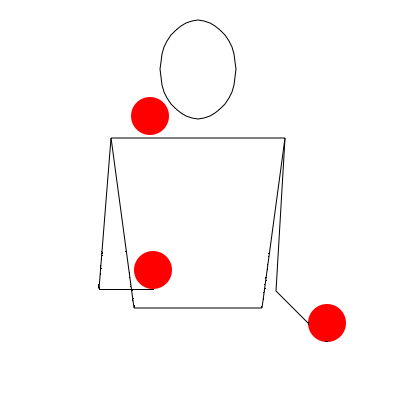



In [ ]:
TOPFLIP=re.findall(r'\b\d+\b',TOPICS)
TOPS=pd.DataFrame(TOPFLIP)
TOPS=TOPS.astype('int')
TOPS
TOPS= TOPS[TOPS[0] !=0]
TOPS2=TOPS
TOPS2
TOPS3=pd.DataFrame(TOPS2[0])
TOPS3

REMOVE = re.compile('"[^"]*"')
for i in range(10):
  TOPS.iloc[i]=str(REMOVE.findall(TOPICS)[i])
  #if i is 1:
TOPS    

TOPS=TOPS[:10]
TOPS=TOPS.reset_index()
TOPS2=TOPS2.reset_index()
TOPS3=TOPS3.reset_index()
TOPS['ONE']=TOPS3[0]

TOPS['TWO']=TOPS3[0]

TOPS[0]
TOPS['THREE']=TOPS[0]

TOPS = TOPS[TOPS.columns[TOPS.columns.isin([0,'TWO'])]] 
TOPS[0]=pd.DataFrame(TOPS[0]).applymap(lambda x: x.replace('"', ''))
TOPS=TOPS.replace('machine', 'machine learning')
TOPS

TOPS['TWO']=TOPS['TWO'].astype('int')*.001

float(TOPS['TWO'].loc[i]+(float(rn.randrange(1,9)))*.9)
TOPS['FOUR']=TOPS['TWO']
for i in range (int(len(TOPS['TWO']))):
  TOPS['FOUR'].loc[i]=float(TOPS['TWO'].loc[i]+(float(rn.randrange(1,9)))*.001)
TOPS['FIVE']=TOPS['FOUR'].pct_change() * 1

TOPS=TOPS.bfill()
TOPS[:1]['FIVE']=float(TOPS[:1]['FIVE'])*.1+TOPS[:1]['FIVE']

TOPS['x'] = TOPS['FIVE'].rank()
TOPS['y'] = TOPS['FOUR'].rank()
val=TOPS[0]
#______

xs = TOPS[ 'x'].to_numpy()
ys = TOPS['y'].to_numpy()
val=TOPS[0].to_numpy()
#______
TOPS['topic']=TOPS[0]
TOPS['weight']=TOPS['TWO']

TOPS4=TOPS[TOPS.columns[TOPS.columns.isin(['topic','weight'])]] 
TOPS4.style.bar().hide_index()

TWOCOL = TOPS[TOPS.columns[TOPS.columns.isin(['x','y'])]] 
TWOCOL


,x,y
0,1.0,10.0
1,2.0,9.0
2,3.0,5.0
3,9.0,8.0
4,4.0,4.0
5,8.0,6.5
6,5.0,2.0
7,7.0,3.0
8,6.0,1.0
9,10.0,6.5


#5. K-Means Analysis

In [ ]:

# K M E A N S

MAT = TWOCOL.values

KMEAN = sklearn.cluster.KMeans(n_clusters=5)

KMEAN.fit(MAT)

labels = KMEAN.labels_

RESULTS = pd.DataFrame([TWOCOL.index,labels]).T

TOPS['SIX']=RESULTS[1]

s=pd.DataFrame([i**2*2+2 for i in list(TOPS['FIVE'])])
s=s*-10
s=s.rank()
s=s*100
s=s.rank()


#6. Draft the Topic Map

In [ ]:

def Topic_Map():
  plt.rcParams['font.family'] = 'sans-serif'
  plt.rcParams['font.sans-serif'] = ['AppleGothic'] + plt.rcParams['font.sans-serif']
  fig, ax = plt.subplots()
  ax.axis("off")
  cola=[0, 1, 2]
  groups = TOPS.groupby('SIX')
  colors={0:'red', 1:'k', 2:'green', 3:'blue', 4: 'orange'}    
  plt.scatter(x=xs,y=ys, s=s,c=TOPS['SIX'].map(colors))
  for x,y,z in zip(xs,ys,val):
    label = z
    plt.title('2021 Survey Topic Keywords', y=1.12, fontsize=18)
    plt.annotate(label, 
                 (x,y),
                 textcoords="offset points", 
                 size=10,
                 xytext=(-1,10), 
                 ha='center') 

#7. Topic Map

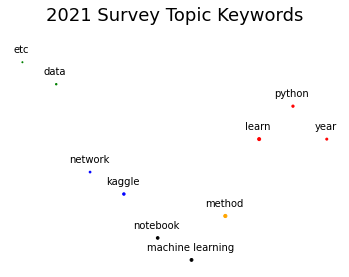

In [ ]:
Topic_Map()